In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, tqdm
import seaborn as sns
import scipy.io
import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import shutil
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

Data Structure:
cycle:    top level structure array containing the charge, discharge and impedance operations
    type:     operation  type, can be charge, discharge or impedance
    ambient_temperature:    ambient temperature (degree C)
    time:     the date and time of the start of the cycle, in MATLAB  date vector format
    data:    data structure containing the measurements
       for charge the fields are:
        Voltage_measured:     Battery terminal voltage (Volts)
        Current_measured:    Battery output current (Amps)
        Temperature_measured:     Battery temperature (degree C)
        Current_charge:        Current measured at charger (Amps)
        Voltage_charge:        Voltage measured at charger (Volts)
        Time:            Time vector for the cycle (secs)
       for discharge the fields are:
        Voltage_measured:     Battery terminal voltage (Volts)
        Current_measured:    Battery output current (Amps)
        Temperature_measured:     Battery temperature (degree C)
        Current_charge:        Current measured at load (Amps)
        Voltage_charge:        Voltage measured at load (Volts)
        Time:            Time vector for the cycle (secs)
        Capacity:        Battery capacity (Ahr) for discharge till 2.7V 
       for impedance the fields are:
        Sense_current:        Current in sense branch (Amps)
        Battery_current:    Current in battery branch (Amps)
        Current_ratio:        Ratio of the above currents 
        Battery_impedance:    Battery impedance (Ohms) computed from raw data
        Rectified_impedance:    Calibrated and smoothed battery impedance (Ohms) 
        Re:            Estimated electrolyte resistance (Ohms)
        Rct:            Estimated charge transfer resistance (Ohms)

In [29]:
def load_data(battery):
    import scipy.io
    import pandas as pd
    import datetime

    # .mat dosyasını yükle
    mat = scipy.io.loadmat(f'NASAdataset/{battery}.mat')

    # # .mat içeriğindeki anahtarları göster
    # print("MAT içeriği anahtarları:", mat.keys())

    # Veriye eriş
    battery_struct = mat[battery]

    # Eğer veri (1,1) şekline sahipse [0,0] ile eriş
    if isinstance(battery_struct, np.ndarray):
        battery_struct = battery_struct[0, 0]

    cycles = battery_struct['cycle'][0]
    # print('Toplam döngü sayısı:', len(cycles))

    counter = 0
    dataset = []
    capacity_data = []
    resistance_data = []

    for i, row in enumerate(cycles):
        if row['type'][0] == 'discharge':
            ambient_temperature = row['ambient_temperature'][0][0]
            t = row['time'][0]
            date_time = datetime.datetime(int(t[0]), int(t[1]), int(t[2]), int(t[3]), int(t[4])) + datetime.timedelta(seconds=int(t[5]))

            data = row['data']
            capacity = data[0][0]['Capacity'][0][0]

            for j in range(len(data[0][0]['Voltage_measured'][0])):
                dataset.append([
                    counter + 1,
                    ambient_temperature,
                    date_time,
                    capacity,
                    data[0][0]['Voltage_measured'][0][j],
                    data[0][0]['Current_measured'][0][j],
                    data[0][0]['Temperature_measured'][0][j],
                    data[0][0]['Current_load'][0][j],
                    data[0][0]['Voltage_load'][0][j],
                    data[0][0]['Time'][0][j]
                ])

            capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
            counter += 1
        elif row['type'][0] == 'impedance':
            # Attempt to safely extract values
            try:
                
                re_val = data[0][0]['Re'][0][0]
                rct_val = data[0][0]['Rct'][0][0]
                resistance_data.append([counter + 1, ambient_temperature, date_time, re_val, rct_val])
            except:
                continue

    # print("Örnek veri satırı:", dataset[0])
   
    df_dataset = pd.DataFrame(dataset, columns=[
        'cycle', 'ambient_temperature', 'datetime',
        'capacity', 'voltage_measured', 'current_measured',
        'temperature_measured', 'current_load', 'voltage_load', 'time'
    ])

    df_capacity = pd.DataFrame(capacity_data, columns=[
        'cycle', 'ambient_temperature', 'datetime', 'capacity'
    ])

    df_resistance = pd.DataFrame(resistance_data, columns=[
        'cycle', 'ambient_temperature', 'datetime', 'Re', 'Rct'
    ])

    return df_dataset, df_resistance 
# Load data for two batteries
train_data, resistance_b0005 = load_data('B0005')
full_data_b0006, resistance_b0006 = load_data('B0006')

# Toplam döngü (cycle) sayısını al
total_cycles = full_data_b0006['cycle'].max()

# %50 validation - %50 test ayırımı yap (örneğin)
split_point = int(total_cycles * 0.5)

# Validation verisi (ilk yarısı)
val_data = full_data_b0006[full_data_b0006['cycle'] <= split_point].reset_index(drop=True)
val_resistance = resistance_b0006[resistance_b0006['cycle'] <= split_point].reset_index(drop=True)

# Test verisi (ikinci yarısı)
test_data = full_data_b0006[full_data_b0006['cycle'] > split_point].reset_index(drop=True)
test_resistance = resistance_b0006[resistance_b0006['cycle'] > split_point].reset_index(drop=True)


print("Validation data size:", len(val_data))
print("Test data size:", len(test_data))
print("Training data size:", len(train_data))

Validation data size: 24142
Test data size: 26143
Training data size: 50285


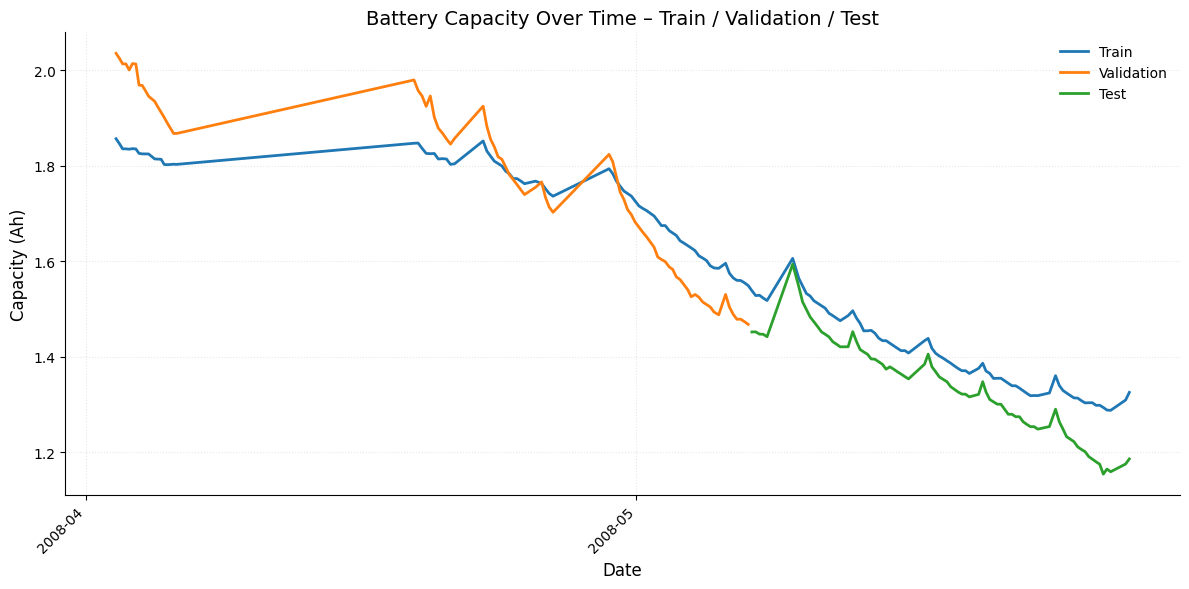

In [111]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure datetime columns are in datetime format
train_data.loc[:, 'datetime'] = pd.to_datetime(train_data['datetime'])
val_data.loc[:, 'datetime'] = pd.to_datetime(val_data['datetime'])
test_data.loc[:, 'datetime'] = pd.to_datetime(test_data['datetime'])

# Plot capacity over time
plt.figure(figsize=(12, 6), tight_layout=True)

plt.plot(train_data['datetime'], train_data['capacity'], label='Train', color='#1f77b4', linewidth=2)
plt.plot(val_data['datetime'], val_data['capacity'], label='Validation', color='#ff7f0e', linewidth=2)
plt.plot(test_data['datetime'], test_data['capacity'], label='Test', color='#2ca02c', linewidth=2)

plt.title('Battery Capacity Over Time – Train / Validation / Test', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Capacity (Ah)', fontsize=12)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle=':', alpha=0.3)
plt.legend(frameon=False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

# Filter for cycles 1-50
train_filtered = train_data[train_data['cycle'] <= 50]
val_filtered = val_data[val_data['cycle'] <= 50]
test_filtered = test_data[test_data['cycle'] <= 50]

# Aggregate mean capacity by date
train_agg = train_filtered.groupby('datetime')['capacity'].reset_index()
val_agg = val_filtered.groupby('datetime')['capacity'].reset_index()
test_agg = test_filtered.groupby('datetime')['capacity'].reset_index()

# --- Plot Train and Validation Together ---
plt.figure(figsize=(10, 5), tight_layout=True)
plt.plot(train_agg['datetime'], train_agg['capacity'], color='#1f77b4', linewidth=2, label='Train')      # blue
plt.plot(val_agg['datetime'], val_agg['capacity'], color='#ff7f0e', linewidth=2, label='Validation')    # orange

plt.title('Capacity Degradation (Cycles 1–50) – Train & Validation', fontsize=12)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Capacity (Ah)', fontsize=10)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_locator(MaxNLocator(6))
plt.ylim(bottom=0)
plt.grid(True, linestyle=':', alpha=0.3)
plt.legend(frameon=False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

# --- Plot for Test Data Only ---
plt.figure(figsize=(10, 5), tight_layout=True)
plt.plot(test_agg['datetime'], test_agg['capacity'], color='#2ca02c', linewidth=2, label='Test')  # green

plt.title('Capacity Degradation (Cycles 1–50) – Test', fontsize=12)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Capacity (Ah)', fontsize=10)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_locator(MaxNLocator(6))
plt.ylim(bottom=0)
plt.grid(True, linestyle=':', alpha=0.3)
plt.legend(frameon=False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()


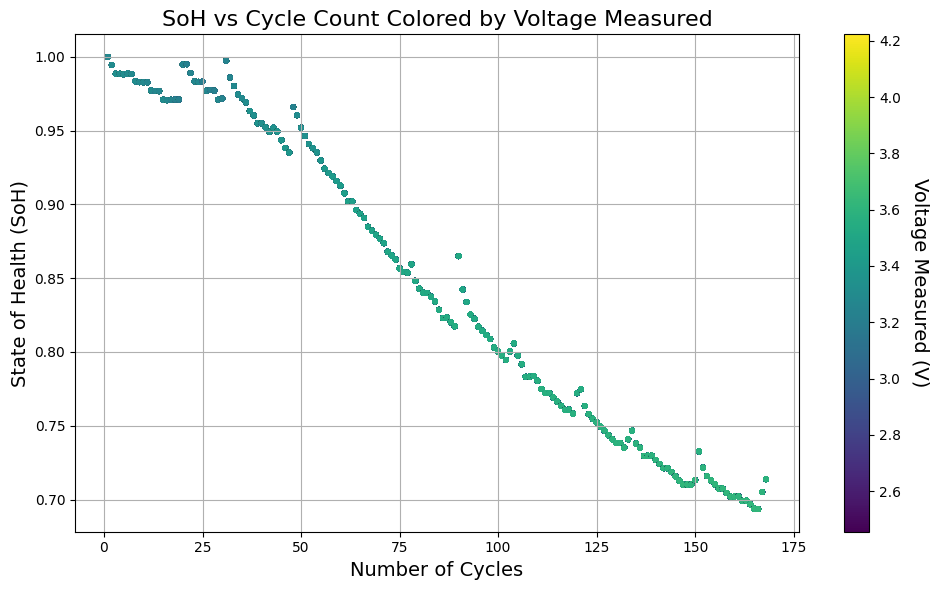

In [112]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming the first value in the 'capacity' column is the initial capacity (C)
C = train_data['capacity'][0]

# Calculate the SoH for each row in the DataFrame
train_data['SoH'] = train_data['capacity'] / C

# Now you can proceed with the combined visualization as you planned
# Scatter plot: Cycle vs SoH, colored by resistance values
plt.figure(figsize=(10, 6))
scatter = plt.scatter(train_data['cycle'], train_data['SoH'],
                      c=train_data['voltage_measured'], s=10, cmap='viridis')

# Colorbar for voltage
cbar = plt.colorbar(scatter)
cbar.set_label('Voltage Measured (V)', fontsize=14, rotation=-90, labelpad=20)

# Labels and title
plt.xlabel('Number of Cycles', fontsize=14)
plt.ylabel('State of Health (SoH)', fontsize=14)
plt.title('SoH vs Cycle Count Colored by Voltage Measured', fontsize=16)

# Grid and layout adjustments
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [113]:
# plot_df = dis_ele.loc[(dis_ele['cycle']>=1),['cycle','SoH']]
# sns.set_style("white")
# plt.figure(figsize=(8, 5))
# plt.plot(plot_df['cycle'], plot_df['SoH'])
# #Draw threshold
# plt.plot([0.,len(capacity)], [0.70, 0.70])
# plt.ylabel('SOH')
# # make x-axis ticks legible
# adf = plt.gca().get_xaxis().get_major_formatter()
# plt.xlabel('cycle')
# plt.title('Discharge B0005')

In [114]:
C = train_data['capacity'][0]
soh = []
for i in range(len(train_data)):
  soh.append([train_data['capacity'][i] / C])
soh = pd.DataFrame(data=soh, columns=['SoH'])
train_data['SoH']=soh


SoH                     1.000000
capacity                1.000000
voltage_load            0.181684
voltage_measured        0.135859
time                    0.119542
current_measured       -0.132162
temperature_measured   -0.143717
current_load           -0.407819
datetime               -0.942151
cycle                  -0.986857
ambient_temperature          NaN
Name: SoH, dtype: float64


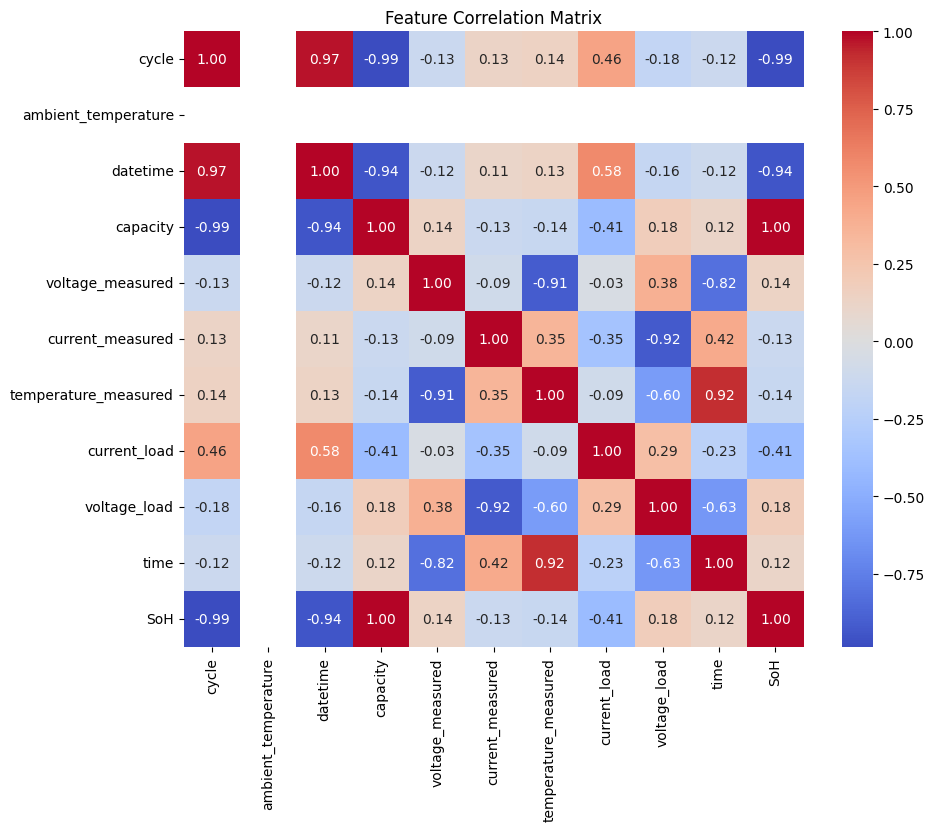

In [115]:
# Compute correlations
correlation_matrix = train_data.corr()

# Show correlation between features and SOH
print(correlation_matrix['SoH'].sort_values(ascending=False))

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

In [116]:
attribs=['voltage_measured', 'voltage_load', 'temperature_measured','capacity'
 ]
train_data1 = train_data[attribs]
sc = MinMaxScaler()
train_data_scaled = sc.fit_transform(train_data1)
print(train_data_scaled.shape)


(50285, 4)


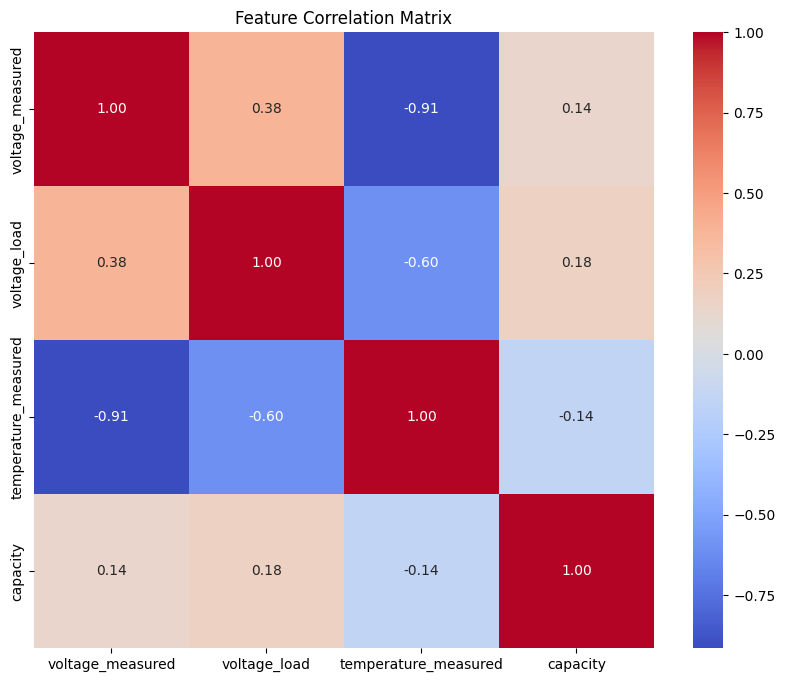

In [117]:
# Compute correlations
correlation_matrix = train_data1.corr()



plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

In [118]:
# --- Validation Set ---

val_data1 = val_data[attribs]
val_data_scaled = sc.transform(val_data1)  # Use same scaler as training
print("Val shape:", val_data_scaled.shape)


Val shape: (24142, 4)


In [119]:

# --- Test Set ---

test_data1 = test_data[attribs]
test_data_scaled = sc.transform(test_data1)  # Use same scaler as training
print("Test shape:", test_data_scaled.shape)


Test shape: (26143, 4)


In [6]:

def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        # The new sequence should have 4 features and 67 timesteps
        X.append(data[i:i + sequence_length].T)  # Transpose the sequence: (4, 67)
        y.append(data[i + sequence_length, 0])  # You can select the first feature or any other feature for the target
    return np.array(X), np.array(y)


sequence_length = 67

X_train, y_train = create_sequences(train_data_scaled, sequence_length)

# Create sequences for validation data
X_val, y_val = create_sequences(val_data_scaled, sequence_length)

# Create sequences for test data
X_test, y_test = create_sequences(test_data_scaled, sequence_length)

# Check the shapes
print("X_train shape:", X_train.shape)  # Should print (num_samples, 67, 4)
print("y_train shape:", y_train.shape)  # Should print (num_samples, )
print("X_val shape:", X_val.shape)      # Should print (num_samples, 67, 4)
print("y_val shape:", y_val.shape)      # Should print (num_samples, )
print("X_test shape:", X_test.shape)    # Should print (num_samples, 67, 4)
print("y_test shape:", y_test.shape)    # Should print (num_samples, )

X_train shape: (80389, 4, 67)
y_train shape: (80389,)
X_val shape: (20047, 4, 67)
y_val shape: (20047,)
X_test shape: (50218, 4, 67)
y_test shape: (50218,)


In [121]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [8]:
from torch.utils.data import DataLoader, TensorDataset


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoader for batching
batch_size = 512 # You can change the batch size as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check the shapes of the first batch
for batch_x, batch_y in train_loader:
    print(f"Batch x shape: {batch_x.shape}")  # Should be [batch_size, 67, 1]
    print(f"Batch y shape: {batch_y.shape}")  # Should be [batch_size, 1]
    break  # Only print the first batch for inspection

Batch x shape: torch.Size([512, 4, 128])
Batch y shape: torch.Size([512])


### GRU MODEL

In [17]:

PATH = 'GRU_model.pth'  # Path to the saved weights
GRU_model = torch.load(PATH, map_location=torch.device('cpu'),weights_only=False)

GRU_model =GRU_model.backbone
GRU_model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
GRU_model.to(device)  # Move the model to the device

GRU(
  (net): GRU(4, 128, num_layers=2, batch_first=True)
  (predictor): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [2]:
def calculate_metrics_sklearn(y_true, y_pred):
    """Calculate R², MAE, MSE, and MAPE using sklearn metrics."""
    # R²
    r2 = r2_score(y_true, y_pred)

    # MAE (Mean Absolute Error)
    mae = mean_absolute_error(y_true, y_pred)

    # MSE (Mean Squared Error)
    mse = mean_squared_error(y_true, y_pred)

    # MAPE (Mean Absolute Percentage Error)
    # mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # Multiply by 100 to get percentage

    return r2, mae, mse

def Train(model, train_loader, valid_loader, test_loader, args, save_folder=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)  # Ensure the model is on the correct device

    # Initialize optimizer and scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.step_size, gamma=args.gamma)

    # Define loss function
    mse_loss = torch.nn.MSELoss()

    min_loss = 10
    stop = 0
    train_losses = []
    valid_losses = []
    best_state = None

    # Store metrics for train, validation, and test
    train_r2_values = []
    valid_r2_values = []

    for e in range(1, args.n_epoch + 1):
        # --------- Train one epoch manually ---------
        model.train()
        train_loss = 0
        all_train_preds = []
        all_train_labels = []
        for data, label in train_loader:
            data, label = data.to(device), label.to(device)
            label = label.unsqueeze(1)
            # print("Data batch shape:", data.shape)  # Should be [512, ...]
            # print("Label batch shape:", label.shape)
            pred = model(data)
            # print("Predicted shape:", pred.shape)
            # print("Target shape:", label.shape)
            loss = mse_loss(pred, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            all_train_preds.append(pred.cpu().detach().numpy())
            all_train_labels.append(label.cpu().detach().numpy())

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Calculate metrics for training
        all_train_preds = np.concatenate(all_train_preds, axis=0)
        all_train_labels = np.concatenate(all_train_labels, axis=0)
        train_r2, train_mae,train_mse = calculate_metrics_sklearn(all_train_labels, all_train_preds)
        train_r2_values.append(train_r2)

        scheduler.step()

        # --------- Validation manually ---------
        model.eval()
        valid_loss = 0
        all_valid_preds = []
        all_valid_labels = []
        with torch.no_grad():
            for data, label in valid_loader:
                data, label = data.to(device), label.to(device)
                label = label.unsqueeze(1)
                pred = model(data)
                loss = mse_loss(pred, label)
                valid_loss += loss.item()

                all_valid_preds.append(pred.cpu().detach().numpy())
                all_valid_labels.append(label.cpu().detach().numpy())

        valid_loss /= len(valid_loader)
        valid_losses.append(valid_loss)

        # Calculate metrics for validation
        all_valid_preds = np.concatenate(all_valid_preds, axis=0)
        all_valid_labels = np.concatenate(all_valid_labels, axis=0)
        valid_r2, valid_mae, valid_mse = calculate_metrics_sklearn(all_valid_labels, all_valid_preds)
        valid_r2_values.append(valid_r2)

        lr = optimizer.state_dict()['param_groups'][0]['lr']
        
        # Print each epoch's training and validation results
        print(f"Epoch [{e}/{args.n_epoch}] - Train Loss: {train_loss:.5f} | Train R²: {train_r2:.5f} | Train MAE: {train_mae:.5f} | Train MSE: {train_mse:.5f}")
        print(f"             - Valid Loss: {valid_loss:.5f} | Valid R²: {valid_r2:.5f} | Valid MAE: {valid_mae:.5f} | Valid MSE: {valid_mse:.5f}")
    
        
        if e % 10 == 0:
            print()  # Newline every 10 epochs for clarity
        delta = 1e-2 
        # --------- Save best model ---------
        if valid_loss < min_loss - delta:
            best_state = model.state_dict()
            min_loss = valid_loss
            stop = 0
        else: stop += 1
        # --------- Early stopping ---------
        if stop >= args.early_stop:
            print("\nEarly stopping triggered.")
            break

    # --------- After all epochs, evaluate on test set ---------
    test_loss = 0
    all_test_preds = []
    all_test_labels = []
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(device), label.to(device)
            label = label.unsqueeze(1)
            pred = model(data)
            loss = mse_loss(pred, label)
            test_loss += loss.item()

            all_test_preds.append(pred.cpu().detach().numpy())
            all_test_labels.append(label.cpu().detach().numpy())

    test_loss /= len(test_loader)

    # Flatten the predictions and labels for metric calculations
    all_test_preds = np.concatenate(all_test_preds, axis=0)
    all_test_labels = np.concatenate(all_test_labels, axis=0)
    
    # Calculate metrics for test set
    test_r2, test_mae, test_mse = calculate_metrics_sklearn(all_test_labels, all_test_preds)

    # Print test results at the end of training
    print(f"Final Test Loss: {test_loss:.5f}, Test R²: {test_r2:.5f}, Test MAE: {test_mae:.5f}, Test MSE: {test_mse:.5f}")

    # --------- Save model ---------
    # if save_folder is not None and best_state is not None:
    #     torch.save(best_state, save_folder + '/best_model.pth')

    return train_losses, valid_losses, train_r2_values, valid_r2_values, test_loss, test_r2,all_test_labels, all_test_preds


In [19]:
class Args:
    n_epoch = 100
    lr = 0.0001
    step_size = 30
    gamma = 0.5
    early_stop = 10

args = Args()
train_losses, valid_losses, train_r2_values, valid_r2_values, test_loss, test_r2 ,all_test_labels, all_test_preds = Train(GRU_model, train_loader, val_loader, test_loader, args, save_folder="my_models")

Epoch [1/100] - Train Loss: 0.02732 | Train R²: -0.60248 | Train MAE: 0.12373 | Train MSE: 0.02755
             - Valid Loss: 0.02069 | Valid R²: -0.09099 | Valid MAE: 0.10892 | Valid MSE: 0.02112
Epoch [2/100] - Train Loss: 0.01787 | Train R²: -0.04766 | Train MAE: 0.10171 | Train MSE: 0.01801
             - Valid Loss: 0.01815 | Valid R²: 0.04282 | Valid MAE: 0.10044 | Valid MSE: 0.01853
Epoch [3/100] - Train Loss: 0.01266 | Train R²: 0.25982 | Train MAE: 0.08267 | Train MSE: 0.01272
             - Valid Loss: 0.00954 | Valid R²: 0.49918 | Valid MAE: 0.06465 | Valid MSE: 0.00970
Epoch [4/100] - Train Loss: 0.00480 | Train R²: 0.72122 | Train MAE: 0.03911 | Train MSE: 0.00479
             - Valid Loss: 0.00569 | Valid R²: 0.69985 | Valid MAE: 0.04555 | Valid MSE: 0.00581
Epoch [5/100] - Train Loss: 0.00252 | Train R²: 0.85337 | Train MAE: 0.02437 | Train MSE: 0.00252
             - Valid Loss: 0.00415 | Valid R²: 0.78246 | Valid MAE: 0.02894 | Valid MSE: 0.00421
Epoch [6/100] - Train 

In [20]:
gru_nasa_loss=test_loss
gru_nasa_r2=test_r2

%store gru_nasa_r2
%store gru_nasa_loss

Stored 'gru_nasa_r2' (float)
Stored 'gru_nasa_loss' (float)


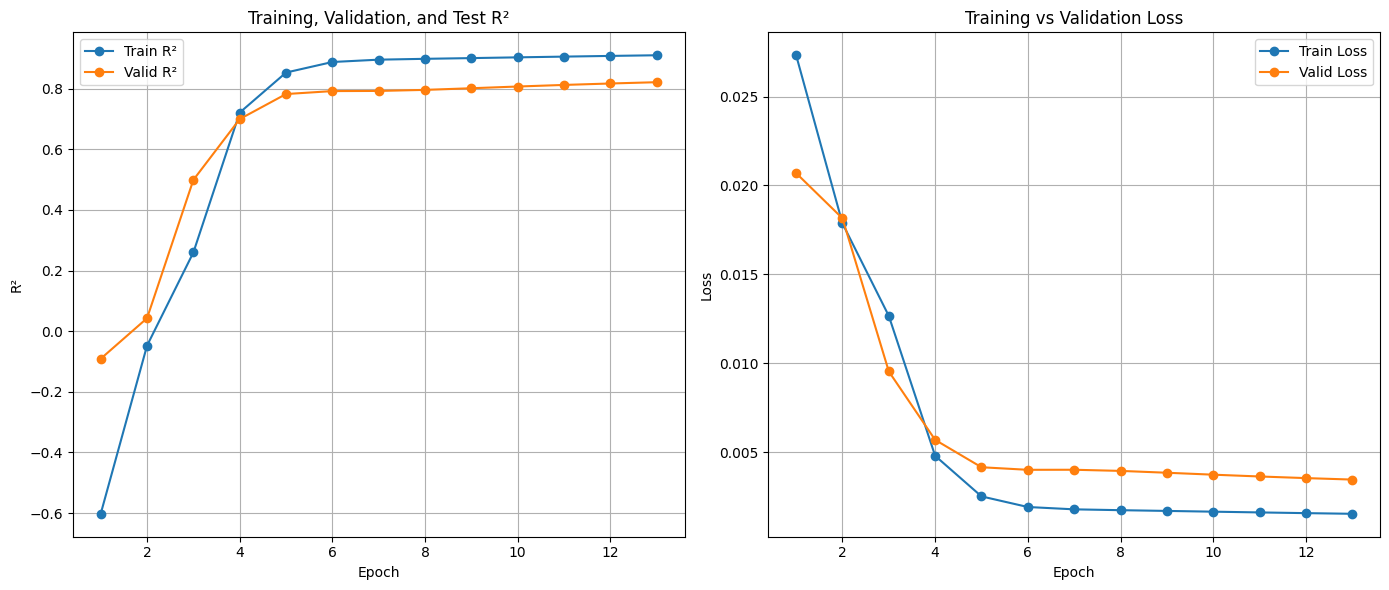

In [21]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 6))
# R² Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_r2_values, label='Train R²', marker='o')
plt.plot(epochs, valid_r2_values, label='Valid R²', marker='o')

plt.xlabel('Epoch')
plt.ylabel('R²')
plt.title('Training, Validation, and Test R²')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, valid_losses, label='Valid Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### ATTENTİON MODEL

In [27]:

PATH = 'Attention_model.pth'  # Path to the saved weights
ATTENTİON_model = torch.load(PATH, map_location=torch.device('cpu'),weights_only=False)
ATTENTİON_model =ATTENTİON_model.backbone

# Set the model to evaluation mode
ATTENTİON_model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ATTENTİON_model.to(device)  # Move the model to the device

Attention(
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (linear1): Linear(in_features=128, out_features=128, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=128, out_features=128, bias=True)
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (l

In [28]:
class Args:
    n_epoch = 100
    lr = 0.0001
    step_size = 30
    gamma = 0.5
    early_stop = 10

args = Args()
train_losses, valid_losses, train_r2_values, valid_r2_values, test_loss, test_r2,all_test_labels, all_test_preds = Train(ATTENTİON_model, train_loader, val_loader, test_loader, args, save_folder="my_models")

Epoch [1/100] - Train Loss: 0.00548 | Train R²: 0.68147 | Train MAE: 0.04340 | Train MSE: 0.00548
             - Valid Loss: 0.94761 | Valid R²: -47.92709 | Valid MAE: 0.85267 | Valid MSE: 0.94938
Epoch [2/100] - Train Loss: 0.00812 | Train R²: 0.52813 | Train MAE: 0.04474 | Train MSE: 0.00812
             - Valid Loss: 0.01414 | Valid R²: 0.26978 | Valid MAE: 0.08975 | Valid MSE: 0.01417
Epoch [3/100] - Train Loss: 0.00225 | Train R²: 0.86900 | Train MAE: 0.02651 | Train MSE: 0.00225
             - Valid Loss: 0.00609 | Valid R²: 0.68574 | Valid MAE: 0.04940 | Valid MSE: 0.00610
Epoch [4/100] - Train Loss: 0.00167 | Train R²: 0.90272 | Train MAE: 0.02321 | Train MSE: 0.00167
             - Valid Loss: 0.00483 | Valid R²: 0.75105 | Valid MAE: 0.04339 | Valid MSE: 0.00483
Epoch [5/100] - Train Loss: 0.00144 | Train R²: 0.91632 | Train MAE: 0.02157 | Train MSE: 0.00144
             - Valid Loss: 0.00431 | Valid R²: 0.77785 | Valid MAE: 0.04038 | Valid MSE: 0.00431
Epoch [6/100] - Train L

In [29]:
att_nasa_loss=test_loss
att_nasa_r2=test_r2

%store att_nasa_r2
%store att_nasa_loss

Stored 'att_nasa_r2' (float)
Stored 'att_nasa_loss' (float)


### CNN MODEL

In [30]:

PATH = 'CNN_model.pth'  # Path to the saved weights
CNN_model = torch.load(PATH, map_location=torch.device('cpu'),weights_only=False)
CNN_model =CNN_model.backbone

# Set the model to evaluation mode
CNN_model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CNN_model.to(device)  # Move the model to the device

CNN(
  (layer1): ResBlock(
    (conv): Sequential(
      (0): Conv1d(4, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (skip_connection): Sequential(
      (0): Conv1d(4, 16, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (relu): ReLU()
  )
  (layer2): ResBlock(
    (conv): Sequential(
      (0): Conv1d(16, 32, kernel_size=(3,), stride=(2,), padding=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [31]:
class Args:
    n_epoch = 100
    lr = 0.0001
    step_size = 30
    gamma = 0.5
    early_stop = 10

args = Args()
train_losses, valid_losses, train_r2_values, valid_r2_values, test_loss, test_r2,all_test_labels, all_test_preds = Train(CNN_model, train_loader, val_loader, test_loader, args)

Epoch [1/100] - Train Loss: 0.00246 | Train R²: 0.85727 | Train MAE: 0.02945 | Train MSE: 0.00246
             - Valid Loss: 0.11526 | Valid R²: -4.94691 | Valid MAE: 0.31216 | Valid MSE: 0.11539
Epoch [2/100] - Train Loss: 0.00134 | Train R²: 0.92233 | Train MAE: 0.01916 | Train MSE: 0.00134
             - Valid Loss: 0.09953 | Valid R²: -4.13278 | Valid MAE: 0.29125 | Valid MSE: 0.09960
Epoch [3/100] - Train Loss: 0.00105 | Train R²: 0.93912 | Train MAE: 0.01599 | Train MSE: 0.00105
             - Valid Loss: 0.04959 | Valid R²: -1.55771 | Valid MAE: 0.18634 | Valid MSE: 0.04963
Epoch [4/100] - Train Loss: 0.00081 | Train R²: 0.95300 | Train MAE: 0.01350 | Train MSE: 0.00081
             - Valid Loss: 0.03541 | Valid R²: -0.82602 | Valid MAE: 0.14814 | Valid MSE: 0.03543
Epoch [5/100] - Train Loss: 0.00071 | Train R²: 0.95897 | Train MAE: 0.01251 | Train MSE: 0.00071
             - Valid Loss: 0.03521 | Valid R²: -0.81709 | Valid MAE: 0.14895 | Valid MSE: 0.03526
Epoch [6/100] - Trai

In [32]:
cnn_nasa_loss=test_loss
cnn_nasa_r2=test_r2

%store cnn_nasa_r2
%store cnn_nasa_loss

Stored 'cnn_nasa_r2' (float)
Stored 'cnn_nasa_loss' (float)


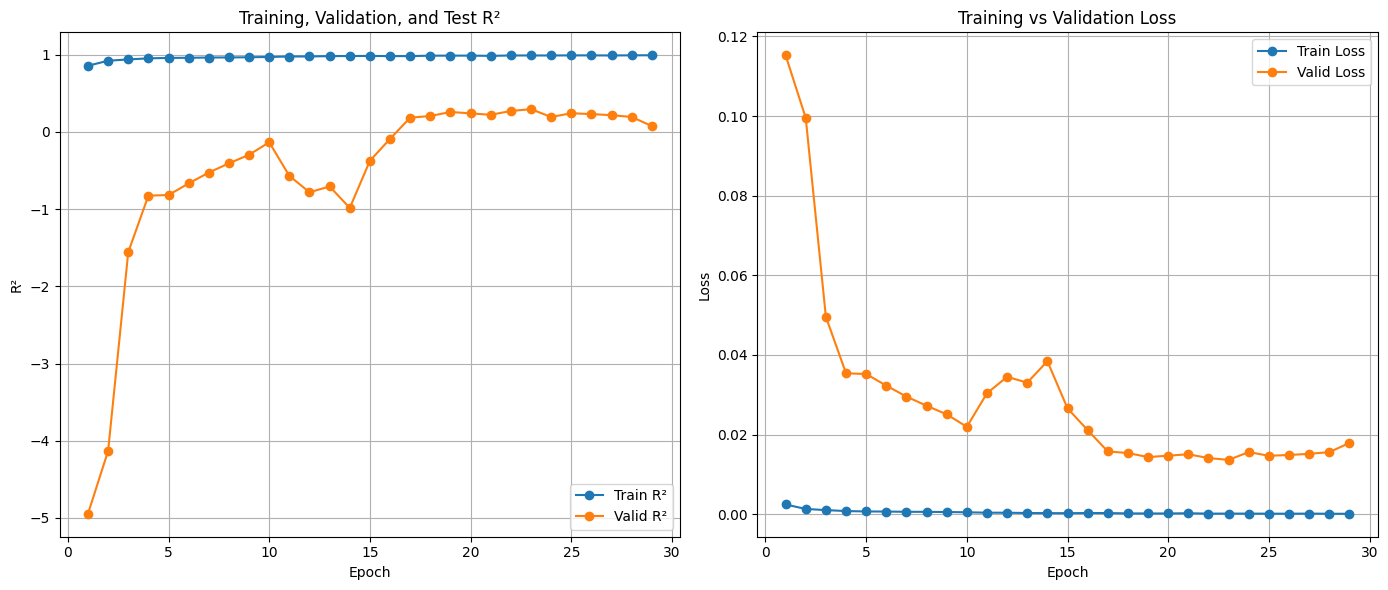

In [33]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 6))
# R² Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_r2_values, label='Train R²', marker='o')
plt.plot(epochs, valid_r2_values, label='Valid R²', marker='o')

plt.xlabel('Epoch')
plt.ylabel('R²')
plt.title('Training, Validation, and Test R²')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, valid_losses, label='Valid Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### LSTM MODEL

In [34]:
PATH = 'LSTM_model.pth'  # Path to the saved weights
LSTM_model = torch.load(PATH, map_location=torch.device('cpu'), weights_only=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LSTM_model.to(device)  # Move the model to the device

LSTM_model =LSTM_model.backbone

# Set the model to evaluation mode
LSTM_model.eval()


LSTM(
  (net): LSTM(4, 128, num_layers=2, batch_first=True)
  (predictor): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [35]:
class Args:
    n_epoch = 100
    lr = 0.0001
    step_size = 30
    gamma = 0.5
    early_stop = 10

args = Args()
train_losses, valid_losses, train_r2_values, valid_r2_values, test_loss, test_r2,all_test_labels, all_test_preds = Train(LSTM_model, train_loader, val_loader, test_loader, args, save_folder="my_models")

Epoch [1/100] - Train Loss: 0.00759 | Train R²: 0.55909 | Train MAE: 0.05112 | Train MSE: 0.00759
             - Valid Loss: 0.02795 | Valid R²: -0.44322 | Valid MAE: 0.13701 | Valid MSE: 0.02800
Epoch [2/100] - Train Loss: 0.00273 | Train R²: 0.84157 | Train MAE: 0.02852 | Train MSE: 0.00273
             - Valid Loss: 0.02156 | Valid R²: -0.11283 | Valid MAE: 0.11749 | Valid MSE: 0.02159
Epoch [3/100] - Train Loss: 0.00229 | Train R²: 0.86708 | Train MAE: 0.02639 | Train MSE: 0.00229
             - Valid Loss: 0.01681 | Valid R²: 0.13210 | Valid MAE: 0.10107 | Valid MSE: 0.01684
Epoch [4/100] - Train Loss: 0.00202 | Train R²: 0.88273 | Train MAE: 0.02489 | Train MSE: 0.00202
             - Valid Loss: 0.01327 | Valid R²: 0.31510 | Valid MAE: 0.08767 | Valid MSE: 0.01329
Epoch [5/100] - Train Loss: 0.00182 | Train R²: 0.89418 | Train MAE: 0.02367 | Train MSE: 0.00182
             - Valid Loss: 0.01075 | Valid R²: 0.44535 | Valid MAE: 0.07727 | Valid MSE: 0.01076
Epoch [6/100] - Train L

In [36]:
lstm_calce_loss=test_loss
lstm_calce_r2=test_r2

%store lstm_calce_r2
%store lstm_calce_loss

Stored 'lstm_calce_r2' (float)
Stored 'lstm_calce_loss' (float)


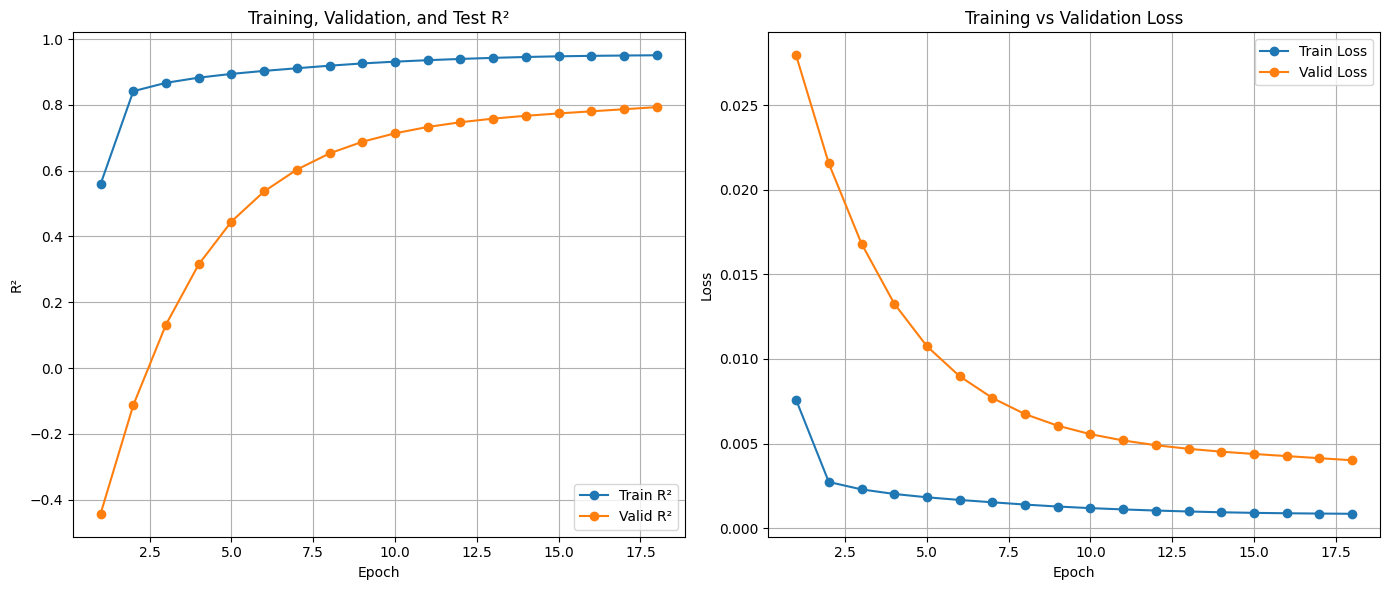

In [37]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 6))
# R² Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_r2_values, label='Train R²', marker='o')
plt.plot(epochs, valid_r2_values, label='Valid R²', marker='o')

plt.xlabel('Epoch')
plt.ylabel('R²')
plt.title('Training, Validation, and Test R²')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, valid_losses, label='Valid Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

data = {
    'Dataset': ['D1', 'D1', 'D2', 'D2', 'D3', 'D3'],
    'Model': ['CNN', 'LSTM', 'CNN', 'LSTM', 'CNN', 'LSTM'],
    'MAE': [0.05, 0.04, 0.07, 0.06, 0.08, 0.07],
    'R²': [0.98, 0.99, 0.95, 0.96, 0.93, 0.94]
}
df = pd.DataFrame(data)

import matplotlib.pyplot as plt
import numpy as np

# Group by Dataset and Model
metrics = ['MAE', 'R²']
datasets = df['Dataset'].unique()
models = df['Model'].unique()
x = np.arange(len(datasets))  # Datasets as x-axis
width = 0.35  # Bar width

fig, ax = plt.subplots(figsize=(12, 6))

# Plot each metric
for i, metric in enumerate(metrics):
    for j, model in enumerate(models):
        # Filter data for the current model and metric
        values = df[df['Model'] == model][metric]
        offset = width * i
        bars = ax.bar(x + offset + j*width/2, values, width/2, label=f'{model} {metric}')
        ax.bar_label(bars, padding=3, fmt='%.2f')

ax.set_xticks(x + width / 2)
ax.set_xticklabels(datasets)
ax.set_ylabel('Score')
ax.set_title('CNN vs LSTM Performance Across Datasets')
ax.legend()
plt.tight_layout()
plt.show()

### MLP MODEL

In [42]:
def load_data(battery):
    import scipy.io
    import pandas as pd
    import datetime

    # .mat dosyasını yükle
    mat = scipy.io.loadmat(f'NASAdataset/{battery}.mat')

    # # .mat içeriğindeki anahtarları göster
    # print("MAT içeriği anahtarları:", mat.keys())

    # Veriye eriş
    battery_struct = mat[battery]

    # Eğer veri (1,1) şekline sahipse [0,0] ile eriş
    if isinstance(battery_struct, np.ndarray):
        battery_struct = battery_struct[0, 0]

    cycles = battery_struct['cycle'][0]
    # print('Toplam döngü sayısı:', len(cycles))

    counter = 0
    dataset = []
    capacity_data = []
    resistance_data = []

    for i, row in enumerate(cycles):
        if row['type'][0] == 'discharge':
            ambient_temperature = row['ambient_temperature'][0][0]
            t = row['time'][0]
            date_time = datetime.datetime(int(t[0]), int(t[1]), int(t[2]), int(t[3]), int(t[4])) + datetime.timedelta(seconds=int(t[5]))

            data = row['data']
            capacity = data[0][0]['Capacity'][0][0]

            for j in range(len(data[0][0]['Voltage_measured'][0])):
                dataset.append([
                    counter + 1,
                    ambient_temperature,
                    date_time,
                    capacity,
                    data[0][0]['Voltage_measured'][0][j],
                    data[0][0]['Current_measured'][0][j],
                    data[0][0]['Temperature_measured'][0][j],
                    data[0][0]['Current_load'][0][j],
                    data[0][0]['Voltage_load'][0][j],
                    data[0][0]['Time'][0][j]
                ])

            capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
            counter += 1
        elif row['type'][0] == 'impedance':
            # Attempt to safely extract values
            try:
                
                re_val = data[0][0]['Re'][0][0]
                rct_val = data[0][0]['Rct'][0][0]
                resistance_data.append([counter + 1, ambient_temperature, date_time, re_val, rct_val])
            except:
                continue

    # print("Örnek veri satırı:", dataset[0])
   
    df_dataset = pd.DataFrame(dataset, columns=[
        'cycle', 'ambient_temperature', 'datetime',
        'capacity', 'voltage_measured', 'current_measured',
        'temperature_measured', 'current_load', 'voltage_load', 'time'
    ])

    df_capacity = pd.DataFrame(capacity_data, columns=[
        'cycle', 'ambient_temperature', 'datetime', 'capacity'
    ])

    df_resistance = pd.DataFrame(resistance_data, columns=[
        'cycle', 'ambient_temperature', 'datetime', 'Re', 'Rct'
    ])

    return df_dataset, df_resistance 
# Load data for two batteries
# Load data for B0006 and B0007
train_data, resistance_b0005 = load_data('B0005')
val_data, resistance_b0006 = load_data('B0006')
test_data, resistance_b0007 = load_data('B0007')

# Toplam döngü (cycle) sayısını al for B0006
total_cycles_val = val_data['cycle'].max()

# %50 validation - %50 test ayırımı yap (B0006 for validation)
split_point_val = int(total_cycles_val * 0.5)

# Validation verisi (ilk yarısı from B0006)
val_data = val_data[val_data['cycle'] <= split_point_val].reset_index(drop=True)
val_resistance = resistance_b0006[resistance_b0006['cycle'] <= split_point_val].reset_index(drop=True)

# Test verisi (ikinci yarısı from B0007)
test_data = test_data.reset_index(drop=True)
test_resistance = resistance_b0007.reset_index(drop=True)

print("Validation data size:", len(val_data))
print("Test data size:", len(test_data))
print("Training data size:", len(train_data))


Validation data size: 24142
Test data size: 50285
Training data size: 50285


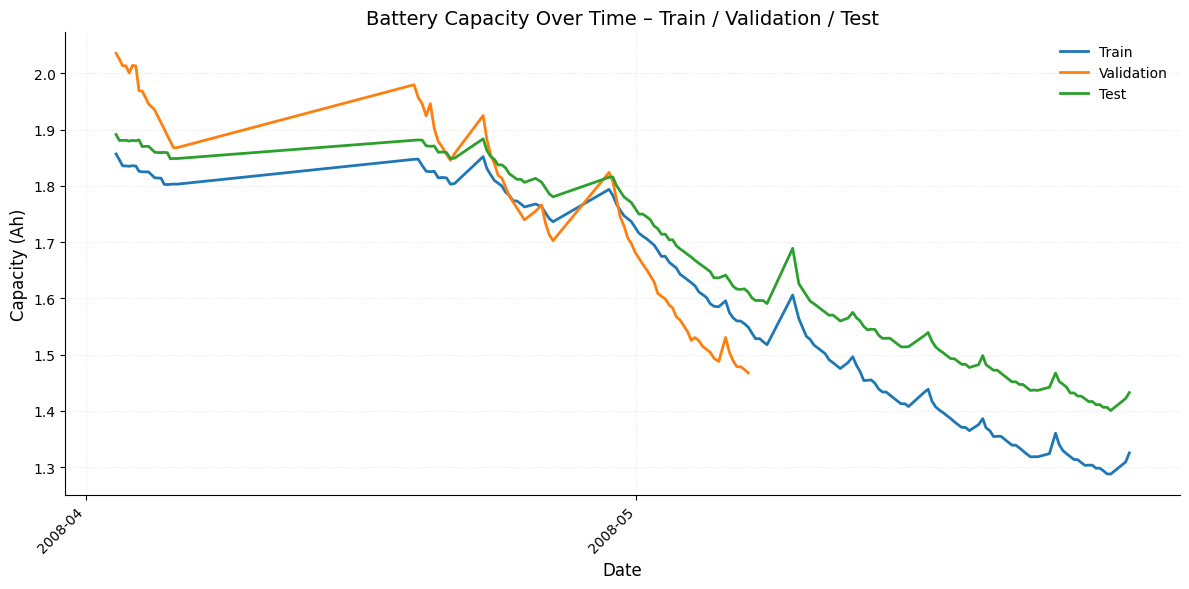

In [43]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure datetime columns are in datetime format
train_data.loc[:, 'datetime'] = pd.to_datetime(train_data['datetime'])
val_data.loc[:, 'datetime'] = pd.to_datetime(val_data['datetime'])
test_data.loc[:, 'datetime'] = pd.to_datetime(test_data['datetime'])

# Plot capacity over time
plt.figure(figsize=(12, 6), tight_layout=True)

plt.plot(train_data['datetime'], train_data['capacity'], label='Train', color='#1f77b4', linewidth=2)
plt.plot(val_data['datetime'], val_data['capacity'], label='Validation', color='#ff7f0e', linewidth=2)
plt.plot(test_data['datetime'], test_data['capacity'], label='Test', color='#2ca02c', linewidth=2)

plt.title('Battery Capacity Over Time – Train / Validation / Test', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Capacity (Ah)', fontsize=12)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle=':', alpha=0.3)
plt.legend(frameon=False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


In [44]:
attribs=['voltage_measured', 'current_measured', 'temperature_measured','capacity'
 ]
train_data1 = train_data[attribs]
sc = MinMaxScaler()
train_data_scaled = sc.fit_transform(train_data1)
print(train_data_scaled.shape)


# --- Test Set ---
# --- Validation Set ---

val_data1 = val_data[attribs]
val_data_scaled = sc.transform(val_data1)  # Use same scaler as training
print("Val shape:", val_data_scaled.shape)

test_data1 = test_data[attribs]
test_data_scaled = sc.transform(test_data1)  # Use same scaler as training
print("Test shape:", test_data_scaled.shape)

(50285, 4)
Val shape: (24142, 4)
Test shape: (50285, 4)


In [45]:
sequence_length = 128


X_train, y_train = create_sequences(train_data_scaled, sequence_length)
X_val, y_val = create_sequences(val_data_scaled, sequence_length)
X_test, y_test = create_sequences(test_data_scaled, sequence_length)


# Check the shapes
print("X_train shape:", X_train.shape)  # Should print (50035, 4, 67)
print("y_train shape:", y_train.shape)  # Should print (50035, )
print("X_val shape:", X_val.shape)      # Should print (3181, 4, 67)
print("y_val shape:", y_val.shape)      # Should print (3181, )
print("X_test shape:", X_test.shape)    # Should print (16439, 4, 67)
print("y_test shape:", y_test.shape)    # Should print (16439, )

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create TensorDataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 512  # Change batch size as needed

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check the shapes of the first batch
for batch_x, batch_y in train_loader:
    print(f"Batch x shape: {batch_x.shape}")  # Should be [batch_size, 4, 67]
    print(f"Batch y shape: {batch_y.shape}")  # Should be [batch_size, 1]
    break  # Only print the first batch for inspection


X_train shape: (50157, 4, 128)
y_train shape: (50157,)
X_val shape: (24014, 4, 128)
y_val shape: (24014,)
X_test shape: (50157, 4, 128)
y_test shape: (50157,)
Batch x shape: torch.Size([512, 4, 128])
Batch y shape: torch.Size([512])


In [46]:

PATH = 'MLP_model.pth'  # Path to the saved weights
MLP_model = torch.load(PATH, map_location=torch.device('cpu'),weights_only=False)

MLP_model =MLP_model.backbone
MLP_model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MLP_model.to(device)  # Move the model to the device

MLP(
  (net): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
  )
  (predictor): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [50]:
class Args:
    n_epoch = 100
    lr = 0.0005
    step_size = 15
    gamma = 0.7
    early_stop = 10

args = Args()
train_losses, valid_losses, train_r2_values, valid_r2_values, test_loss, test_r2,all_test_labels, all_test_preds = Train(MLP_model, train_loader, val_loader, test_loader, args, save_folder="my_models")

Epoch [1/100] - Train Loss: 0.01694 | Train R²: 0.01582 | Train MAE: 0.09747 | Train MSE: 0.01694
             - Valid Loss: 0.01977 | Valid R²: -0.01835 | Valid MAE: 0.10408 | Valid MSE: 0.01976
Epoch [2/100] - Train Loss: 0.01703 | Train R²: 0.01053 | Train MAE: 0.09783 | Train MSE: 0.01703
             - Valid Loss: 0.01979 | Valid R²: -0.01950 | Valid MAE: 0.10416 | Valid MSE: 0.01978
Epoch [3/100] - Train Loss: 0.01703 | Train R²: 0.01029 | Train MAE: 0.09784 | Train MSE: 0.01703
             - Valid Loss: 0.01979 | Valid R²: -0.01984 | Valid MAE: 0.10419 | Valid MSE: 0.01979
Epoch [4/100] - Train Loss: 0.01703 | Train R²: 0.01018 | Train MAE: 0.09785 | Train MSE: 0.01703
             - Valid Loss: 0.01980 | Valid R²: -0.02001 | Valid MAE: 0.10420 | Valid MSE: 0.01979
Epoch [5/100] - Train Loss: 0.01704 | Train R²: 0.01013 | Train MAE: 0.09786 | Train MSE: 0.01704
             - Valid Loss: 0.01980 | Valid R²: -0.02011 | Valid MAE: 0.10421 | Valid MSE: 0.01979
Epoch [6/100] - Trai

In [ ]:
mlp_nasa_loss=test_loss
mlp_nasa_r2=test_r2

%store mlp_nasa_r2
%store mlp_nasa_loss

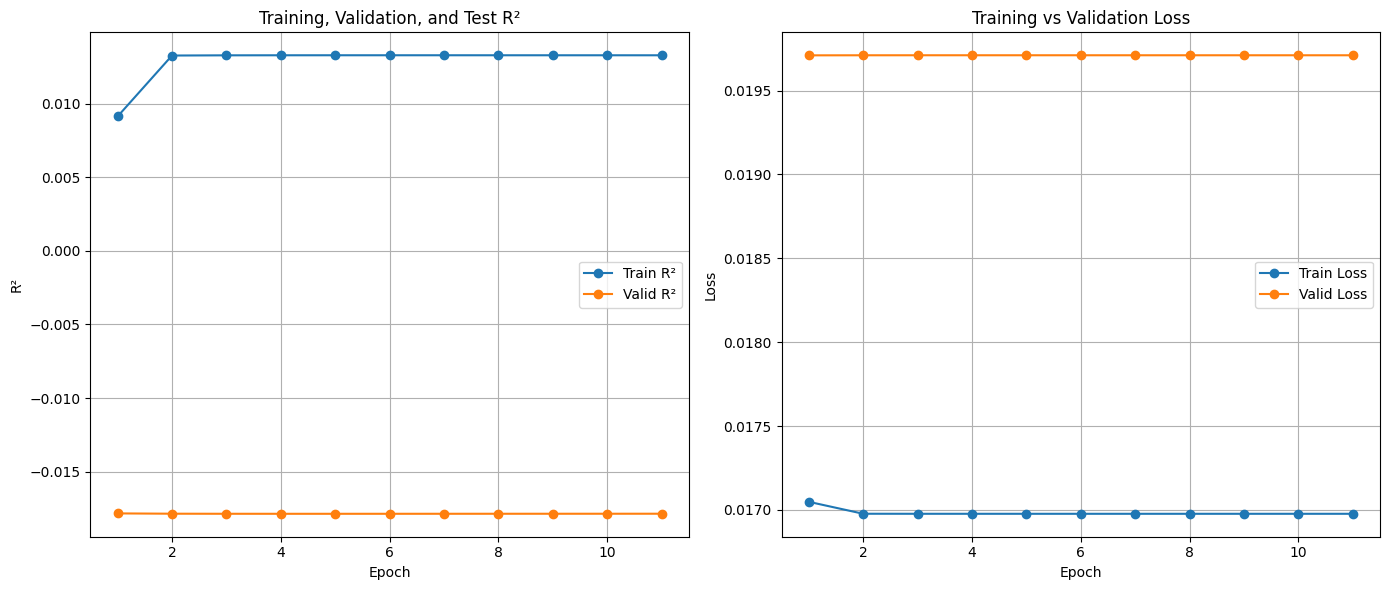

In [26]:

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 6))
# R² Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_r2_values, label='Train R²', marker='o')
plt.plot(epochs, valid_r2_values, label='Valid R²', marker='o')

plt.xlabel('Epoch')
plt.ylabel('R²')
plt.title('Training, Validation, and Test R²')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, valid_losses, label='Valid Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
